In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
# import scipy.integrate

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [3]:
# Compute a periodic convolution
# Edited from: https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    if len(ker) < len(signal):
        ker = np.pad(ker, (0, len(signal)-len(ker)))
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

# Generating PF basis 
def generatePFratesBasis(N_PFs = 120, a=5, theta=9):
    # Number of PFs, peak spike rate (Hz), threshold for visual stim velocity
    pf_spike_rates = np.zeros((N_PFs, len(t)))
    # Array of times of peak response of parallel fibers
    delays = np.linspace(0, 1, N_PFs+1) + T_min_full
    for n in range(N_PFs):
        # PF rates are scaled, thresholded versions of the stimulus, 
        # of which each PF receives a time-shifted version
        pf_spike_rates[n,:] = np.maximum(peak_stim_vel*np.cos(2*np.pi*(t - delays[n])) - theta,0)
        pf_spike_rates[n,:] *= a/np.max(pf_spike_rates[n,:])
    return pf_spike_rates

In [401]:
# Simulation time step size (s)
dt = 2e-3

# Total time per block (s)
T_max_full = 0.75
T_min_full = -0.25
T = T_max_full - T_min_full

T_min = 0
t_min_ind = int((T_min-T_min_full)/dt)
T_max = 0.5
t_max_ind = int((T_max - T_min_full)/dt)


# Array of time steps
t = np.arange(0, int(T/dt))*dt + T_min_full

In [5]:
# Eligibility window

dt_mp = dt
T_mp_max = 0.2

t_mp = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

# PF-CF histograms
N_bins = 100
hist_edges = np.linspace(0, T_mp_max, N_bins+1)

In [243]:
## Model parameters

# postsynaptic PC current response to spikes
exc_current_kernel = np.exp(-(t - t[0])/10e-3)

inh_current_kernel = (np.exp(-(t-t[0])/40e-3) - np.exp(-(t-t[0])/10e-3))
inh_current_kernel *= np.sum(exc_current_kernel)/np.sum(inh_current_kernel)

pc_eye_sensitivity = 5
w_max = 5
w_min = 0
w_mli = w_max/2
avg_sensitivity_to_pc = 0.01 # 1/100
retinal_slip_f = lambda x: np.maximum(-x,0)**3
avg_cf_rate = 1
dw_ltd =  3e-2
dw_ltp = dw_ltd*0.016

dw_ltd_avg =  3e-2
dw_ltp_avg = dw_ltd_avg*0.016

delay = 0.12

decay_rate = 1/(3600) # / s

In [112]:
## Mode rule
hill = lambda x, k_d, n: np.power(x,n)/(k_d**n + np.power(x,n))

dv = 1e-4
N_states = 12
t_states = np.arange(0, int(T_mp_max/dt))*dt
states = np.zeros((len(t_states), N_states))
edges = np.linspace(0, T_mp_max, N_states+1)/dt
for i in range(N_states):
    states[int(edges[i]):int(edges[i+1]),i] = 1 

# timer_std = 7.5e-3
# states = np.zeros((N_states, len(t_states)))
# centers = np.linspace(0, 0.2, N_states)
# for i in range(N_states):
#     states[i,:] = hill(np.exp(-(t_states - centers[i])**2/(2*timer_std**2)),0.6,10)
#     states[i,:] /= np.max(states[i,:])
# #     states[i,:] = np.exp(-(t_states - centers[i])**2/(2*timer_std**2))

In [114]:
dt*((edges[1:]-edges[:-1])/2+edges[:-1])

array([0.00833333, 0.025     , 0.04166667, 0.05833333, 0.075     ,
       0.09166667, 0.10833333, 0.125     , 0.14166667, 0.15833333,
       0.175     , 0.19166667])

In [9]:
# or
delay_distr = np.exp(-(t_states-0.12)**2/0.005**2)
delay_distr /= np.sum(delay_distr)

In [14]:
## Stimulus

peak_stim_vel = 10 # deg/s
f = 1 # Hz
stim_vel_f = lambda t: -peak_stim_vel*np.sin(2*np.pi*f*t)
direct_pathway_f = lambda t: -peak_stim_vel*np.sin(2*np.pi*f*(t-0.04))

In [210]:
stim_vel = stim_vel_f(t)
direct_pathway = direct_pathway_f(t)

In [16]:
N_PFs = 120
pf_spike_rates = generatePFratesBasis(N_PFs)
mli_current = dt*conv_circ(np.ones(N_PFs)@pf_spike_rates, exc_current_kernel)

In [58]:
N_repetitions = 1
N_trials = 3600
plasticity = False
metaplasticity = False
cell_wide = False

PF_samples = [0,38,54]
w_0 = w_mli*np.ones(N_PFs)
w_avg_0 = w_mli*np.ones(N_PFs)
v_0 = np.zeros((N_PFs, N_states))
v_0[:,0] = 1

shuffle=False
target_on=False

pf_noise_amp = 0

In [22]:
rng = np.random.default_rng(seed=0)

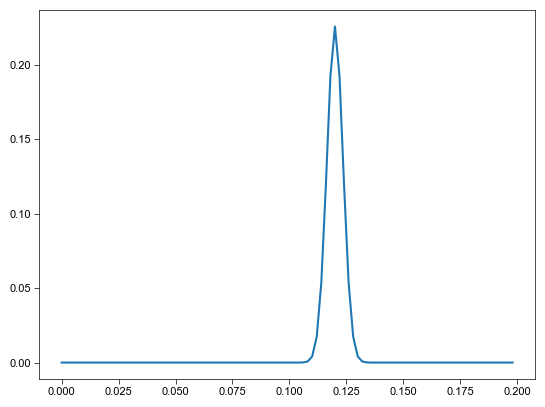

In [263]:
plt.plot(t_states, delay_distr)

In [264]:
def simulateLearningModeOKR(N_repetitions, N_trials, w_0, v_0,
                     avg_sensitivity_to_pc = 0.01, baseline_gain=0.35,
                     history_samples = 0, PF_samples = []):

    inds_random = np.arange(N_PFs)

    eligibility_windows = v_0@states.T

    if history_samples == 0:
            history_samples = N_repetitions
    sample_interval = int(np.floor(N_trials/history_samples))

    eye_history = np.zeros((N_repetitions, len(t), history_samples))
    eye_history_no_noise = np.zeros((N_repetitions, len(t), history_samples))

    hist_history_PF = np.zeros((N_repetitions, len(PF_samples) + 1, N_bins,history_samples))
    state_counts = np.zeros((N_repetitions, len(PF_samples)+1, N_states))

    if metaplasticity and len(PF_samples) > 0:
        vs = np.zeros((N_repetitions, len(PF_samples), N_states, history_samples))

    w_final = np.zeros((N_repetitions, N_PFs))
    w_avg_final = np.zeros((N_repetitions, N_PFs))

    cf_prob_avg = np.zeros((N_repetitions, len(t), history_samples)) # Calculate CF probability 

    if len(PF_samples) > 0:
        w_test = np.zeros((N_repetitions, len(PF_samples), history_samples))
    w_mean = np.zeros((N_repetitions, history_samples))

    for rep in tqdm.notebook.trange(N_repetitions):
        w = np.ones(N_PFs)*w_max/2
        w_avg = np.ones(N_PFs)*w_max/2
        n_to_divide = 0
        sample_count = 1

        # hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
        hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
        cf_prob_rep = np.zeros(len(t))
        
        for tt in tqdm.notebook.trange(N_trials, leave=False):  

            # Generate PF spikes for sample PC
            pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates[inds_random,:]*dt
            pf_spikes_weighted = w@pf_spikes
            pc_current_exc = dt*conv_circ(pf_spikes_weighted/dt, exc_current_kernel)

            # Generate PC firing rate for rest of population
            pc_current_exc_avg_bef = w_avg[inds_random]@(pf_spike_rates)
            pc_current_exc_avg_no_noise = dt*conv_circ(pc_current_exc_avg_bef, exc_current_kernel)

            pc_current_exc_avg = dt*conv_circ(pc_current_exc_avg_bef, exc_current_kernel)

            # Subtract MLI current
            # mli_current_same = dt*conv_circ(np.sum(pf_spikes/dt, axis=0), inh_current_kernel)

            pc_current = pc_current_exc - w_mli*mli_current
            pc_current_avg = pc_current_exc_avg - w_mli*mli_current
            pc_current_avg_no_noise = pc_current_exc_avg_no_noise - w_mli*mli_current

            # Generate eye movement
            eye = (pc_eye_sensitivity*(pc_current_avg*(1-avg_sensitivity_to_pc) + pc_current*avg_sensitivity_to_pc)
                   ) + baseline_gain*direct_pathway
            
            # Calculate retinal slip
            # Assume we are combining N PCs (s.t. avg_sensitivity_to_pc = 1/N)
            # Let the random_target represent the effect of the remaining N-1
    #        retinal_slip = random_target*np.sqrt(avg_sensitivity_to_pc*(1-avg_sensitivity_to_pc)) - eye*avg_sensitivity_to_pc
            retinal_slip = stim_vel - eye

            # Calculate CF probability (here, contraversive RS)
            cf_prob = retinal_slip_f(retinal_slip)
            # Delay the CF probability distribution

            # Rescale so that the average rate over the block is ~1 Hz
            if np.sum(cf_prob) > 0:
                cf_prob /= np.sum(cf_prob)
                cf_prob *= avg_cf_rate*T
            cf_prob_shifted = np.roll(cf_prob, int(delay/dt))
            # cf_prob_shifted = conv_circ(cf_prob, delay_distr)

            if tt > 0 and tt % sample_interval == 0:
                eye_history[rep,:,sample_count] = pc_eye_sensitivity*pc_current
                eye_history_no_noise[rep, :,sample_count] = pc_eye_sensitivity*pc_current_avg_no_noise
                
                hist_history_PF[rep, :, :, sample_count] += hist_history_rep
                cf_prob_avg[rep, :, sample_count] += cf_prob_rep/n_to_divide
                w_mean[rep, sample_count] = np.mean(w)
                if len(PF_samples) > 0:
                    w_test[rep, :, sample_count] = np.copy(w[PF_samples])
                    if metaplasticity:
                        vs[rep,:, :, sample_count] = np.copy(v[PF_samples,:])
                sample_count += 1
                
            ## Choose CF spikes
            if np.sum(cf_prob) > 0:
                # cf_prob_cdf = np.cumsum(cf_prob)
                # cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)+0.12
                cf_prob_rep += cf_prob_shifted
                n_to_divide += 1
                cf_prob_cdf = np.cumsum(cf_prob_shifted)
                cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)

            ## Do plasticity
            for j in range(N_PFs):
                eligibility_window = eligibility_windows[j,:]
                ## Firing rates
                
                pf_rate = pf_spike_rates[inds_random[j],:]
                if np.sum(cf_prob_shifted) > 0:
                    pf_eligibility = dt*conv_circ(pf_rate,eligibility_window)
                    dw_avg_d = np.sum(pf_eligibility*cf_prob_shifted)
                else:
                    dw_avg_d = 0
                dw_avg_p = np.sum(pf_rate*dt)

                w_avg[j] += -dw_ltd_avg*dw_avg_d + dw_ltp_avg*dw_avg_p
#                 dw_d_avg[rep, j,tt] = dw_avg_d
#                 dw_p_avg[rep, j,tt] = dw_avg_p

                for s in np.where(pf_spikes[j,:])[0]:
#                     dw_p[rep, j,tt] += 1
                    w[j] += dw_ltp

                    if np.sum(cf_prob) > 0:
                        spike_time_1 = cf_spike_time - t[s]
                        # use circular assumption for simplicity
    #                     spike_time_2 = spike_time_1 - T_max_full + T_min_full
                        spike_time_2 = spike_time_1 + T_max_full - T_min_full

                        if 0 <= spike_time_1 <= 0.2 or 0<= spike_time_2 <= 0.2:
                            if 0<=spike_time_1<=0.2:
                                cf_spike_ind = int(np.floor((spike_time_1)/dt))
                                active_timer = np.digitize(spike_time_1, edges*dt)-1
                                hist_bin = np.digitize(spike_time_1, hist_edges)-1
                            else:
                                cf_spike_ind = int(np.floor((spike_time_2)/dt))
                                active_timer = np.digitize(spike_time_2, edges*dt)-1
                                hist_bin = np.digitize(spike_time_2, hist_edges)-1

                            state_counts[rep, 0, active_timer] += 1
                            hist_history_rep[0, hist_bin] += 1
                            for p in range(len(PF_samples)):
                                if j == PF_samples[p]:
                                    state_counts[rep, p+1, active_timer] += 1
                                    hist_history_rep[p+1, hist_bin] += 1

                            ## Plasticity
                            dw = eligibility_window[cf_spike_ind]
#                             dw_d[rep, j,tt] += dw
                            w[j] -= dw*dw_ltd

                if w_avg[j] < w_min: w_avg[j] = w_min
                elif w_avg[j] > w_max: w_avg[j] = w_max
                w_avg[j] += decay_rate*(w_max/2 - w_avg[j])


                if w[j] < w_min: w[j] = w_min
                elif w[j] > w_max: w[j] = w_max
                w[j] += decay_rate*(w_max/2 - w[j])
        w_final[rep,:] = np.copy(w)
        w_avg_final[rep,:] = np.copy(w_avg)
    return_dict = {
        'w_final': w_final,
        'w_avg_final': w_avg_final,
        'eye_history': eye_history,
        'eye_history_no_noise': eye_history_no_noise,
        'hist_history_PF': hist_history_PF,
        'state_counts': state_counts,
        'cf_prob_avg': cf_prob_avg,
    }
    if len(PF_samples) > 0:
        return_dict['w_test'] = w_test
        
    return return_dict

# Untuned

In [417]:
dw_ltd =  1.25e-2
dw_ltp = dw_ltd*0.016

dw_ltd_avg =  1.25e-2
dw_ltp_avg = dw_ltd_avg*0.016

In [432]:
sol = simulateLearningModeOKR(30, 3600, np.arange(N_PFs)*w_max/2, v_0, PF_samples=[38, 54,80], history_samples = 20,
                             baseline_gain=0.35)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [328]:
sol_2 = simulateLearningModeOKR(10, 3600, np.arange(N_PFs)*w_max/2, v_0, PF_samples=[38, 54,80], history_samples = 20,
                             baseline_gain=0.35)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [332]:
sol_3 = simulateLearningModeOKR(10, 3600, np.arange(N_PFs)*w_max/2, v_0, PF_samples=[38, 54,80], history_samples = 20,
                             baseline_gain=0.35)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

<BarContainer object of 120 artists>

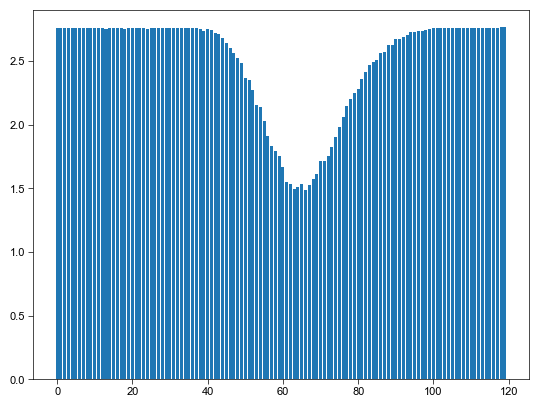

In [317]:
plt.bar(np.arange(N_PFs), np.mean(sol['w_final'],axis=0))

<BarContainer object of 120 artists>

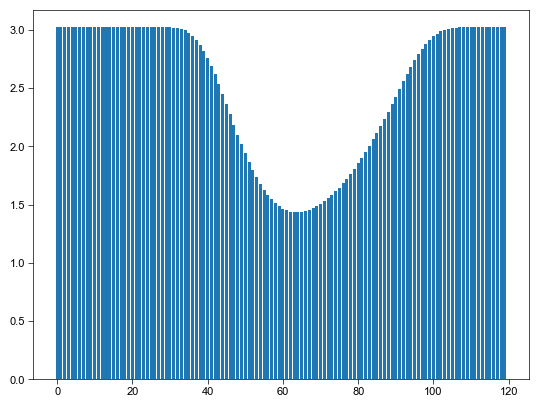

In [318]:
plt.bar(np.arange(N_PFs), w_avg)

In [419]:
pc_current_avg_all = np.vstack((sol['eye_history_no_noise'],
                                sol_2['eye_history_no_noise'], 
                                sol_3['eye_history_no_noise']))

pc_current_all = np.vstack((sol['eye_history'],
                            sol_2['eye_history'], 
                            sol_3['eye_history']))

In [434]:
pc_current_avg_all = sol['eye_history_no_noise']
pc_current_all = sol['eye_history']

eye_learned_final = ((pc_current_avg_all*(1-avg_sensitivity_to_pc) + pc_current_all*avg_sensitivity_to_pc)
                   ) 

In [435]:
eye_history_mu = np.mean(eye_learned_final ,axis=0)
eye_history_std = np.std(eye_learned_final,axis=0)

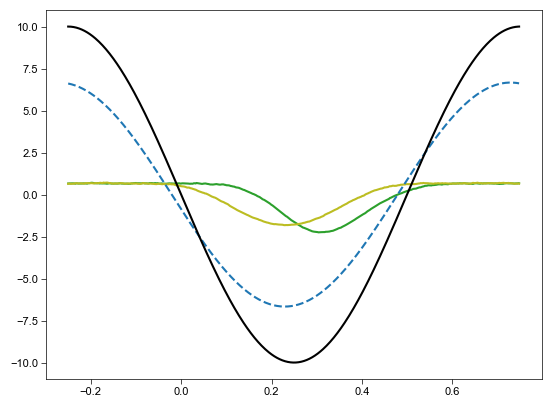

In [444]:
# plt.fill_between(t, eye_history_mu[:,-1]-eye_history_std[:,-1], eye_history_mu[:,-1]+eye_history_std[:,-1], alpha=0.5)
plt.plot(t, eye_history_mu[:,-1], c='C2')
plt.plot(t, eye_history_mu_tuned[:,-1],c='C8')
plt.plot(t, stim_vel - direct_pathway*0.35,c='C0',ls='--')
plt.plot(t, stim_vel, c='k')
# plt.plot(t, direct_pathway)

In [482]:
hist_history_untuned = np.vstack((sol['hist_history_PF'], sol_2['hist_history_PF'], sol_3['hist_history_PF'] ))
eye_history_untuned = np.vstack((sol['eye_history'], sol_2['eye_history'], sol_3['eye_history'] ))
eye_history_no_noise_untuned = np.vstack((sol['eye_history_no_noise'], 
                                          sol_2['eye_history_no_noise'], sol_3['eye_history_no_noise'] ))
w_final_untuned = np.vstack((sol['w_final'], sol_2['w_final'], sol_3['w_final'] ))
w_avg_final_untuned = np.vstack((sol['w_avg_final'], sol_2['w_avg_final'], sol_3['w_avg_final'] ))


In [483]:
np.save('files/okr/hist_history_untuned.npy',hist_history_untuned)
np.save('files/okr/eye_history_untuned.npy',eye_history_untuned)
np.save('files/okr/eye_history_no_noise_untuned.npy',eye_history_no_noise_untuned)
np.save('files/okr/w_final_untuned.npy',w_final_untuned )
np.save('files/okr/w_avg_final_untuned.npy',w_avg_final_untuned )

In [467]:
hist_end = np.sum(hist_history_untuned[:,:,:,-1], axis=0)

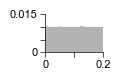

In [488]:
plt.figure(figsize=(0.75,0.5))

i = 0

plt.bar(hist_edges[:-1], hist_end[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/okr-hist-untuned-0.pdf')

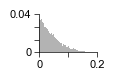

In [501]:
plt.figure(figsize=(0.75,0.5))

i = 3

plt.bar(hist_edges[:-1], hist_end[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.04])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.04, 4))
ax.set_yticklabels([0,'','',0.04])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/okr-hist-untuned-3.pdf')

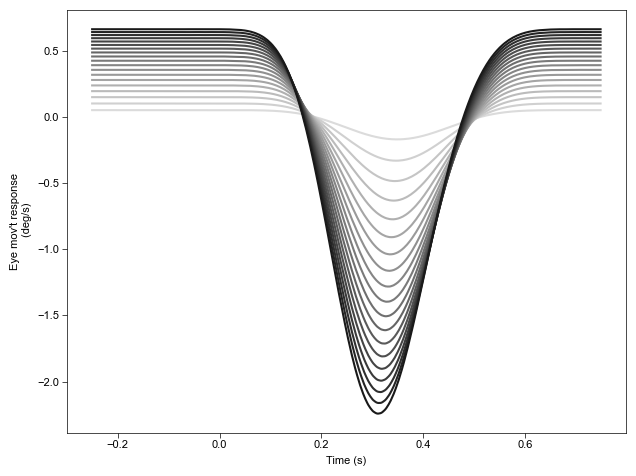

In [460]:
# plt.figure(figsize=(4,3))
for i in range(1, history_samples):
    plt.plot(t, sol['eye_history_no_noise'][0,:,i],c=(1-cs[i],)*3)
plt.xlabel('Time (s)')
plt.ylabel('Eye mov\'t response\n (deg/s)')
plt.tight_layout()
# plt.savefig('2024-05-22/untuned-shuffled-before-eye-evol.png')
# plt.savefig('2024-05-24/tuned-shuffled-eye-evol.png')

# Tuned

In [447]:
dw_ltd =  4e-2
dw_ltp = dw_ltd*0.016

dw_ltd_avg =  4e-2
dw_ltp_avg = dw_ltd_avg*0.016

In [448]:
v_0_tuned = np.zeros((N_PFs, N_states))
v_0_tuned[:,7] = 1

sol_tuned = simulateLearningModeOKR(30, 3600, np.arange(N_PFs)*w_max/2, v_0_tuned, PF_samples=[38, 54,80], 
                                    history_samples = 20)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [449]:
pc_current_avg_all_tuned = sol_tuned['eye_history_no_noise']
pc_current_all_tuned = sol_tuned['eye_history']

eye_learned_final_tuned = ((pc_current_avg_all_tuned*(1-avg_sensitivity_to_pc) 
                            + pc_current_all_tuned*avg_sensitivity_to_pc)
                   ) 

In [450]:
eye_history_mu_tuned = np.mean(eye_learned_final_tuned,axis=0)
eye_history_std_tuned = np.std(eye_learned_final_tuned,axis=0)

In [451]:
t[np.argmin(eye_history_mu_tuned[:,-1])]-0.25, t[np.argmin(eye_history_mu[:,-1])]-0.25

(-0.018000000000000016, 0.05400000000000005)

In [452]:
t[np.argmin(eye_history_mu[:,-1])] - t[np.argmin(eye_history_mu_tuned[:,-1])]

0.07200000000000006

In [492]:
t[np.argmin(eye_history_mu[:,-1]),]

0.6080000000000001

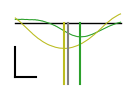

In [498]:
plt.figure(figsize=(1.5,1))

plt.plot([t[t_min_ind], t[t_max_ind]],[0,0], c='k',lw=1)

plt.fill_between(t[t_min_ind:t_max_ind], eye_history_mu[t_min_ind:t_max_ind,-1]-eye_history_std[t_min_ind:t_max_ind,-1], eye_history_mu[t_min_ind:t_max_ind,-1]+eye_history_std[t_min_ind:t_max_ind,-1],
                 color='C2', alpha=0.3, edgecolor=None)

plt.fill_between(t[t_min_ind:t_max_ind], eye_history_mu_tuned[t_min_ind:t_max_ind,-1]-eye_history_std_tuned[t_min_ind:t_max_ind,-1], 
                 eye_history_mu_tuned[t_min_ind:t_max_ind,-1]+eye_history_std_tuned[t_min_ind:t_max_ind,-1], color='C8', alpha=0.3, edgecolor=None)

plt.plot(t[t_min_ind:t_max_ind], eye_history_mu[t_min_ind:t_max_ind,-1], c='C2',lw=0.75)
plt.plot(t[t_min_ind:t_max_ind], eye_history_mu_tuned[t_min_ind:t_max_ind,-1],c='C8',lw=0.75)
# plt.plot(t[t_min_ind:t_max_ind], np.minimum(stim_vel[t_min_ind:t_max_ind],0), c=(0.5,)*3)

plt.plot([t[np.argmin(eye_history_mu[:,-1]),]]*2,[0,-10],c='C2' )
plt.plot([t[np.argmin(eye_history_mu_tuned[:,-1]),]]*2,[0,-10],c='C8' )
plt.plot([t[np.argmin(stim_vel),]]*2,[0,-10],c=(0.5,)*3 )
plt.plot([0,0],[-4,-9], c='k')
plt.plot([0,0.1],[-9,-9],c='k')

plt.axis('off')
plt.savefig('figures/learning-temp-before-after.pdf')
# plt.plot(t, eye_history_mu[:,-1], c='C8')
# plt.plot(t, eye_history_mu_tuned[:,-1],c='C2')
# plt.plot(t, np.minimum(stim_vel,0), c='k')
# plt.plot(t[t_min_ind:t_max_ind], (stim_vel - direct_pathway*0.35)[t_min_ind:t_max_ind],c='C1',ls='--')
# plt.plot(t, direct_pathway)

In [484]:
np.save('files/okr/hist_history_tuned.npy',sol_tuned['hist_history_PF'])
np.save('files/okr/eye_history_tuned.npy',sol_tuned['eye_history'])
np.save('files/okr/eye_history_no_noise_tuned.npy',sol_tuned['eye_history_no_noise'])
np.save('files/okr/w_final_tuned.npy',sol_tuned['w_final'])
np.save('files/okr/w_avg_final_tuned.npy',sol_tuned['w_avg_final'])

In [475]:
hist_end_tuned = np.sum(sol_tuned['hist_history_PF'][:,:,:,-1], axis=0)

[Text(0.0, 0, '0'), Text(0.1, 0, ''), Text(0.2, 0, '0.2')]

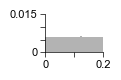

In [476]:
plt.figure(figsize=(0.75,0.5))

i = 0

plt.bar(hist_edges[:-1], hist_end_tuned[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

# plt.savefig('figures/learning-hist-end-0.pdf')

[Text(0.0, 0, '0'), Text(0.1, 0, ''), Text(0.2, 0, '0.2')]

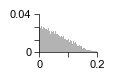

In [477]:
plt.figure(figsize=(0.75,0.5))

i = 3

plt.bar(hist_edges[:-1], hist_end_tuned[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.04])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.04, 4))
ax.set_yticklabels([0,'','',0.04])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

# plt.savefig('figures/learning-hist-end-0.pdf')

In [462]:
history_samples = 20
cs = np.linspace(0.1, 0.9, history_samples)

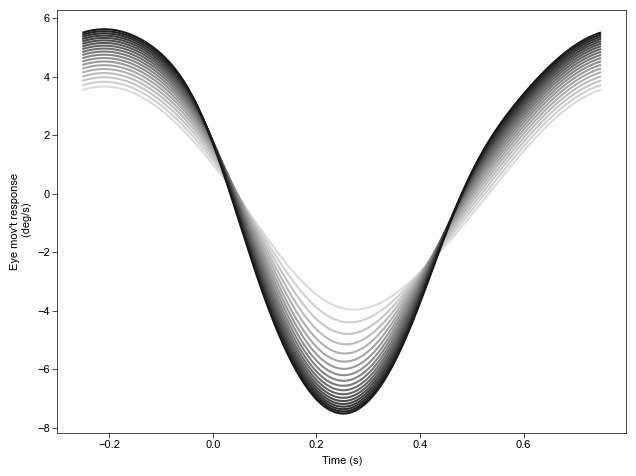

In [464]:
# plt.figure(figsize=(4,3))
for i in range(1, history_samples):
    plt.plot(t, sol_tuned['eye_history_no_noise'][0,:,i]+0.35*direct_pathway,c=(1-cs[i],)*3)
plt.xlabel('Time (s)')
plt.ylabel('Eye mov\'t response\n (deg/s)')
plt.tight_layout()
# plt.savefig('2024-05-22/untuned-shuffled-before-eye-evol.png')
# plt.savefig('2024-05-24/tuned-shuffled-eye-evol.png')

In [363]:
eye_learned_final_tuned = ((sol_tuned['eye_history_no_noise']*(1-avg_sensitivity_to_pc) 
                            + sol_tuned['eye_history']*avg_sensitivity_to_pc)
                   ) 

In [364]:
eye_history_mu_tuned = np.mean(eye_learned_final_tuned ,axis=0)
eye_history_std_tuned = np.std(eye_learned_final_tuned,axis=0)

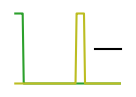

In [391]:
plt.figure(figsize=(1.5,1))

plt.plot(t_states, v_0[0,:]@states.T, c='C2');
plt.plot(t_states, v_0_tuned[0,:]@states.T,c='C8');
plt.plot([0.15, 0.2],[0.5,0.5],c='k')
plt.axis('off')
plt.savefig('figures/eligibility-before-after-temp-diagram.pdf')

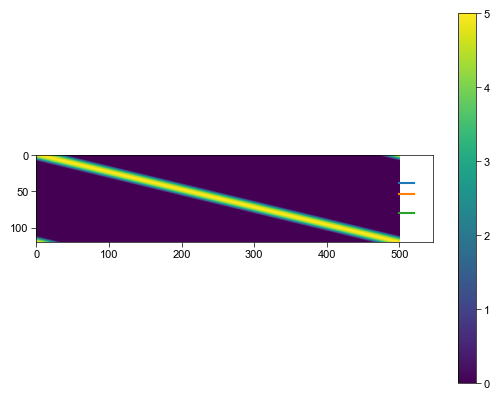

In [502]:
plt.imshow(pf_spike_rates)
plt.plot([500,520], [38,38],clip_on=False)
plt.plot([500,520], [54,54],clip_on=False)
plt.plot([500,520], [80,80],clip_on=False)

# cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=cmap),ax=ax,orientation='horizontal',location='top')
plt.colorbar()
plt.savefig('figures/structured-basis-colorbar.pdf')